In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import json
# from src.utils import rewrite_program_postgres, str_to_program_postgres
import seaborn as sns
import re
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

[user data] # data: 9, f1_median: 0.831
[user data] # data: 9, f1_median: 0.955
[user data] # data: 9, f1_median: 0.808
[user data] # data: 9, f1_median: 0.918
[user data] # data: 9, f1_median: 0.439
[user data] # data: 9, f1_median: 0.365
[user_study_queries_scene_graph], # data: 9, f1_median: 0.997
[user_study_queries_scene_graph], # data: 9, f1_median: 0.975
[user_study_queries_scene_graph], # data: 9, f1_median: 0.966
[user_study_queries_scene_graph], # data: 9, f1_median: 0.994
[user_study_queries_scene_graph], # data: 9, f1_median: 0.969
[user_study_queries_scene_graph], # data: 9, f1_median: 0.41
[user_study_queries_scene_graph-simulated_user_error], # data: 9, f1_median: 0.568
[user_study_queries_scene_graph-simulated_user_error], # data: 9, f1_median: 0.944
[user_study_queries_scene_graph-simulated_user_error], # data: 9, f1_median: 0.855
[user_study_queries_scene_graph-simulated_user_error], # data: 9, f1_median: 0.851
[user_study_queries_scene_graph-simulated_user_error], # 

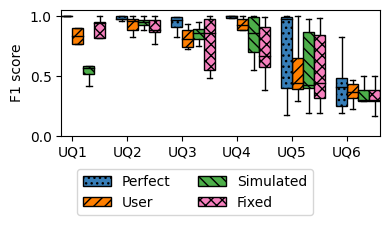

In [2]:
def plot_f1():
    query_strs = [
        "Conjunction(Conjunction(Color_red(o0), Far_3(o0, o1)), Shape_cylinder(o1)); Near_1(o0, o1)",
        "Conjunction(Conjunction(Conjunction(Behind(o0, o1), BottomQuadrant(o1)), Color_purple(o0)), material_metal(o0))",
        "Conjunction(Conjunction(Color_red(o0), Far_3(o0, o1)), Shape_cylinder(o1)); Conjunction(Conjunction(Near_1(o0, o1), RightQuadrant(o2)), TopQuadrant(o2))",
        "Conjunction(Conjunction(Conjunction(Behind(o0, o1), BottomQuadrant(o1)), Color_purple(o0)), material_metal(o0)); TopQuadrant(o1)",
        "Duration(Conjunction(Conjunction(Color_red(o0), Far_3(o0, o1)), Shape_cylinder(o1)), 25); Conjunction(Conjunction(Near_1(o0, o1), RightQuadrant(o2)), TopQuadrant(o2))",
        "Conjunction(Conjunction(Conjunction(Behind(o0, o1), BottomQuadrant(o1)), Color_purple(o0)), material_metal(o0)); TopQuadrant(o1); Duration(Conjunction(BottomQuadrant(o2), RightQuadrant(o2)), 25)"
    ]
    
    fig, ax = plt.subplots(1, 1, figsize = (4, 1.8))
    
    exp_dir = "/mmfs1/gscratch/balazinska/enhaoz/complex_event_video/outputs/"
    datasets = ["user_study_queries_scene_graph", "user_study_queries_scene_graph-simulated_user_error", "user_study_queries_scene_graph-fn_error_rate_0.3-fp_error_rate_0.03"]
    
    hatch_list = ['...', '///', '\\\\\\', 'xxx']
    legend_labels = []

    query_id = ["UQ{}".format(i) for i in range(1, len(query_strs) + 1)]
    handles_f1 = []
    handles_runtime = []
    legend_labels = []
    
    # Processing User study data
    user_f1_list = [[] for _ in range(6)]
    user_output = "/mmfs1/gscratch/balazinska/enhaoz/complex_event_video/outputs/user_study"
    for filename in os.listdir(user_output):
        with open(os.path.join(user_output, filename), "r") as f:
            for line in f:
                if line.startswith("query_id"):
                    qid = int(re.search(r"query_id:\s*(\d+\.?\d*)", line).group(1))
                    median_f1 = float(re.search(r"median F1:\s*(\d+\.?\d*)", line).group(1))
                    user_f1_list[qid].append(median_f1)
    user_f1_list[2], user_f1_list[4], user_f1_list[1], user_f1_list[3], user_f1_list[5] = user_f1_list[1], user_f1_list[2], user_f1_list[3], user_f1_list[4], user_f1_list[5]

    # User study
    user_f1_data = []
    for qid, query_str in enumerate(query_strs):
        user_f1_data = user_f1_list[qid]
        print("[user data] # data: {}, f1_median: {}".format(len(user_f1_data), np.round(np.median(user_f1_data), 3)))
    bp_f1 = ax.boxplot(user_f1_list, 
                   positions=np.array(range(len(user_f1_list)))*5, 
                   sym='.', widths=1, showfliers=False, patch_artist=True, boxprops=dict(facecolor=CB_color_cycle[1], hatch = hatch_list[1]),
                   medianprops = dict(color='black'))   
    handles_f1.append(bp_f1["boxes"][0])
        
    # Simulation
    position_os = [0, 2, 3]
    for idx, dataset_name in enumerate(datasets):

        f1_data = []
        runtime_data = []
        for qid, query_str in enumerate(query_strs):
            if qid in [0, 1, 3]:
                config_name = "nip_10-nin_10-npred_7-depth_3-max_d_75-nvars_3-bw_5-pool_size_25-n_sampled_videos_100-k_100-budget_50-thread_4-lru_None-lambda_0.001"
            else:
                config_name = "nip_15-nin_15-npred_7-depth_3-max_d_75-nvars_3-bw_5-pool_size_25-n_sampled_videos_100-k_100-budget_50-thread_4-lru_None-lambda_0.001"
            f1 = []
            runtime = []
            try:
                with open(os.path.join(exp_dir, dataset_name, "stats", "vocal_postgres-topk", config_name, "{}.json".format(query_str)), "r") as f:
                    stats = json.load(f)
                runtime = np.array(stats["runtime"])
                f1 = np.array(stats["score_median"][:9])
            except:
                pass
            print("[{}], # data: {}, f1_median: {}".format(dataset_name, len(f1), np.round(np.median(f1), 3)))
            f1_data.append(f1)
            runtime_data.append(runtime)  
        bp_f1 = ax.boxplot(f1_data, 
                       positions=np.array(range(len(f1_data)))*5+position_os[idx]-1, 
                       sym='.', widths=1, showfliers=False, patch_artist=True, boxprops=dict(facecolor=CB_color_cycle[position_os[idx]], hatch = hatch_list[position_os[idx]]),
                       medianprops = dict(color='black'))   
        handles_f1.append(bp_f1["boxes"][0])
    handles_f1[0], handles_f1[1] = handles_f1[1], handles_f1[0] 
    ax.set(ylabel="F1 score")
    ax.set_ylim(bottom=0, top=1.05)
    ax.set_xticks(np.arange(-0.5, len(query_id)*5-0.5, 5))
    ax.set_xticklabels(query_id)

#     for ax in axs.flat:
#         ax.label_outer()
    legend_labels = ["Perfect", "User", "Simulated", "Fixed"]
    
    fig.legend(handles_f1, legend_labels, prop={"size":10}, loc='upper center', bbox_to_anchor=(0.5, 0.07),
              fancybox=True, shadow=False, ncol=2)
    plt.subplots_adjust(bottom=0.15)
    fig.tight_layout()
    plt.savefig("figures/user_study_f1.pdf", bbox_inches='tight', pad_inches=0, dpi=600)
    
plot_f1()

[Total time] # data: 9, median: 10.183
[System time] # data: 9, median: 2.5
[mean_time_per_label] # data: 9, mean: 22
[Total time] # data: 9, median: 8.617
[System time] # data: 9, median: 2.45
[mean_time_per_label] # data: 9, mean: 16
[Total time] # data: 9, median: 10.4
[System time] # data: 9, median: 3.983
[mean_time_per_label] # data: 9, mean: 25
[Total time] # data: 9, median: 9.767
[System time] # data: 9, median: 2.633
[mean_time_per_label] # data: 9, mean: 20
[Total time] # data: 9, median: 12.3
[System time] # data: 9, median: 4.317
[mean_time_per_label] # data: 9, mean: 30
[Total time] # data: 9, median: 8.617
[System time] # data: 9, median: 3.683
[mean_time_per_label] # data: 9, mean: 22


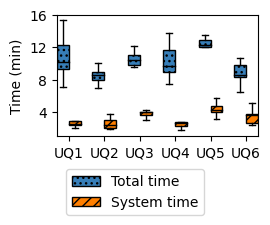

In [3]:
def plot_time():
    query_strs = [
        "Conjunction(Conjunction(Color_red(o0), Far_3(o0, o1)), Shape_cylinder(o1)); Near_1(o0, o1)",
        "Conjunction(Conjunction(Conjunction(Behind(o0, o1), BottomQuadrant(o1)), Color_purple(o0)), material_metal(o0))",
        "Conjunction(Conjunction(Color_red(o0), Far_3(o0, o1)), Shape_cylinder(o1)); Conjunction(Conjunction(Near_1(o0, o1), RightQuadrant(o2)), TopQuadrant(o2))",
        "Conjunction(Conjunction(Conjunction(Behind(o0, o1), BottomQuadrant(o1)), Color_purple(o0)), material_metal(o0)); TopQuadrant(o1)",
        "Duration(Conjunction(Conjunction(Color_red(o0), Far_3(o0, o1)), Shape_cylinder(o1)), 25); Conjunction(Conjunction(Near_1(o0, o1), RightQuadrant(o2)), TopQuadrant(o2))",
        "Conjunction(Conjunction(Conjunction(Behind(o0, o1), BottomQuadrant(o1)), Color_purple(o0)), material_metal(o0)); TopQuadrant(o1); Duration(Conjunction(BottomQuadrant(o2), RightQuadrant(o2)), 25)"
    ]
    
    fig, ax = plt.subplots(1, 1, figsize = (2.8, 1.8))
    
    exp_dir = "/mmfs1/gscratch/balazinska/enhaoz/complex_event_video/outputs/"
    
    hatch_list = ['...', '///', '\\\\\\', 'xxx']
    legend_labels = []

    query_id = ["UQ{}".format(i) for i in range(1, len(query_strs) + 1)]
    handles = []
    legend_labels = []
    
    # Processing User study data
    total_time_list = [[] for _ in range(6)]
    system_time_list = [[] for _ in range(6)]
    user_time_list = [[] for _ in range(6)]
    user_output = "/mmfs1/gscratch/balazinska/enhaoz/complex_event_video/outputs/user_study"
    for filename in os.listdir(user_output):
        with open(os.path.join(user_output, filename), "r") as f:
            for line in f:
                if line.startswith("query_id"):
                    qid = int(re.search(r"query_id:\s*(\d+\.?\d*)", line).group(1))
                    total_time = float(re.search(r"total_time:\s*(\d+\.?\d*)", line).group(1)) / 60
#                     user_time = float(re.search(r"user_time:\s*(\d+\.?\d*)", line).group(1)) / 60
                    system_time = float(re.search(r"system_time:\s*(\d+\.?\d*)", line).group(1)) / 60
                    user_time = float(re.search(r"mean_time_per_label:\s*(\d+\.?\d*)", line).group(1))
                    
                    total_time_list[qid].append(total_time)
                    system_time_list[qid].append(system_time)
                    user_time_list[qid].append(user_time)
    total_time_list[2], total_time_list[4], total_time_list[1], total_time_list[3], total_time_list[5] = total_time_list[1], total_time_list[2], total_time_list[3], total_time_list[4], total_time_list[5]
    system_time_list[2], system_time_list[4], system_time_list[1], system_time_list[3], system_time_list[5] = system_time_list[1], system_time_list[2], system_time_list[3], system_time_list[4], system_time_list[5]
    user_time_list[2], user_time_list[4], user_time_list[1], user_time_list[3], user_time_list[5] = user_time_list[1], user_time_list[2], user_time_list[3], user_time_list[4], user_time_list[5]
    for qid, query_str in enumerate(query_strs):
        total_time_data = total_time_list[qid]
        print("[Total time] # data: {}, median: {}".format(len(total_time_data), np.round(np.median(total_time_data), 3)))
        system_time_data = system_time_list[qid]
        print("[System time] # data: {}, median: {}".format(len(system_time_data), np.round(np.median(system_time_data), 3)))
        user_time_data = user_time_list[qid]
        print("[mean_time_per_label] # data: {}, mean: {:.0f}".format(len(user_time_data), np.round(np.mean(user_time_data), 3)))

    # Total time
    bp = ax.boxplot(total_time_list, 
                   positions=np.array(range(len(total_time_list)))*3, 
                   sym='.', widths=1, showfliers=False, patch_artist=True, boxprops=dict(facecolor=CB_color_cycle[0], hatch = hatch_list[0]),
                   medianprops = dict(color='black'))   
    handles.append(bp["boxes"][0])
    
    # system time
    bp = ax.boxplot(system_time_list, 
                   positions=np.array(range(len(system_time_list)))*3+1, 
                   sym='.', widths=1, showfliers=False, patch_artist=True, boxprops=dict(facecolor=CB_color_cycle[1], hatch = hatch_list[1]),
                   medianprops = dict(color='black'))   
    handles.append(bp["boxes"][0])
    
    
    ax.set(ylabel="Time (min)")
    ax.set_yticks(np.arange(4, 17, 4))
#     ax.set_ylim(bottom=0, top=1.05)
    ax.set_xticks(np.arange(0.5, len(query_id)*3+0.5, 3))
    ax.set_xticklabels(query_id)

            
#     for ax in axs.flat:
#         ax.label_outer()
    legend_labels = ["Total time", "System time"]
    
    fig.legend(handles, legend_labels, prop={"size":10}, loc='upper center', bbox_to_anchor=(0.5, 0.07),
              fancybox=True, shadow=False, ncol=1)
    plt.subplots_adjust(bottom=0.15)
    fig.tight_layout()
    plt.savefig("figures/user_study_time.pdf", bbox_inches='tight', pad_inches=0, dpi=600)
    
plot_time()

In [3]:
# Processing User study data
user_f1_list = [[] for _ in range(6)]
user_tp_list = [0 for _ in range(6)]
user_tn_list = [0 for _ in range(6)]
user_fp_list = [0 for _ in range(6)]
user_fn_list = [0 for _ in range(6)]
user_output = "/mmfs1/gscratch/balazinska/enhaoz/complex_event_video/outputs/user_study"
system_time_breakdown_q2_i5 = []
system_time_breakdown_q2_i10 = []
for filename in os.listdir(user_output):
    with open(os.path.join(user_output, filename), "r") as f:
        for line in f:
            if line.startswith("query_id"):
                qid = int(re.search(r"query_id:\s*(\d+\.?\d*)", line).group(1))
                median_f1 = float(re.search(r"median F1:\s*(\d+\.?\d*)", line).group(1))
                user_f1_list[qid].append(median_f1)
            if line.startswith("TP:"):
                tp_match = re.search(r'TP:\s*(\d+)', line)
                tn_match = re.search(r'TN:\s*(\d+)', line)
                fp_match = re.search(r'FP:\s*(\d+)', line)
                fn_match = re.search(r'FN:\s*(\d+)', line)

                tp = int(tp_match.group(1))
                tn = int(tn_match.group(1))
                fp = int(fp_match.group(1))
                fn = int(fn_match.group(1))

                user_tp_list[qid] += tp
                user_tn_list[qid] += tn
                user_fp_list[qid] += fp
                user_fn_list[qid] += fn
            if line.startswith("system_time_breakdown:") and qid == 2:
                system_time_breakdown = line.split(":")[1].strip()
                system_time_breakdown = eval(system_time_breakdown)
                system_time_breakdown_q2_i5.append(system_time_breakdown[7])
                system_time_breakdown_q2_i10.append(system_time_breakdown[17])

print("system_time_breakdown_q2_i5: {}, mean: {}".format(system_time_breakdown_q2_i5, np.mean(system_time_breakdown_q2_i5)))
print("system_time_breakdown_q2_i10: {}, mean: {}".format(system_time_breakdown_q2_i10, np.mean(system_time_breakdown_q2_i10)))
user_f1_list[2], user_f1_list[4], user_f1_list[1], user_f1_list[3], user_f1_list[5] = user_f1_list[1], user_f1_list[2], user_f1_list[3], user_f1_list[4], user_f1_list[5]
user_tp_list[2], user_tp_list[4], user_tp_list[1], user_tp_list[3], user_tp_list[5] = user_tp_list[1], user_tp_list[2], user_tp_list[3], user_tp_list[4], user_tp_list[5]
user_tn_list[2], user_tn_list[4], user_tn_list[1], user_tn_list[3], user_tn_list[5] = user_tn_list[1], user_tn_list[2], user_tn_list[3], user_tn_list[4], user_tn_list[5]
user_fp_list[2], user_fp_list[4], user_fp_list[1], user_fp_list[3], user_fp_list[5] = user_fp_list[1], user_fp_list[2], user_fp_list[3], user_fp_list[4], user_fp_list[5]
user_fn_list[2], user_fn_list[4], user_fn_list[1], user_fn_list[3], user_fn_list[5] = user_fn_list[1], user_fn_list[2], user_fn_list[3], user_fn_list[4], user_fn_list[5]

for i, (tp, tn, fp, fn) in enumerate(zip(user_tp_list, user_tn_list, user_fp_list, user_fn_list)):
    print("query id: {}, tp: {}, tn: {}, fp: {}, fn: {}, fp rate: {:.3f}, fn rate: {:.3f}".format(i+1, tp, tn, fp, fn, fp / (fp + tn), fn / (fn + tp)))

system_time_breakdown_q1_i5: [21.0, 52.0, 17.0, 41.0, 27.0, 23.0, 26.0, 40.0, 32.0], mean: 31.0
system_time_breakdown_q1_i10: [1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0], mean: 1.3333333333333333
query id: 1, tp: 93, tn: 78, fp: 26, fn: 6, fp rate: 0.250, fn rate: 0.061
query id: 2, tp: 114, tn: 72, fp: 5, fn: 16, fp rate: 0.065, fn rate: 0.123
query id: 3, tp: 50, tn: 69, fp: 14, fn: 5, fp rate: 0.169, fn rate: 0.091
query id: 4, tp: 78, tn: 106, fp: 3, fn: 12, fp rate: 0.028, fn rate: 0.133
query id: 5, tp: 5, tn: 90, fp: 40, fn: 2, fp rate: 0.308, fn rate: 0.286
query id: 6, tp: 2, tn: 132, fp: 4, fn: 5, fp rate: 0.029, fn rate: 0.714
